# Figure 3 & 4: Accuracy vs. m (2x2 grid)

Combined plots for best test accuracy (best_test_acc) and final train accuracy (last train_acc) across m values and architecture/kernel combos. Baseline ViT is excluded.


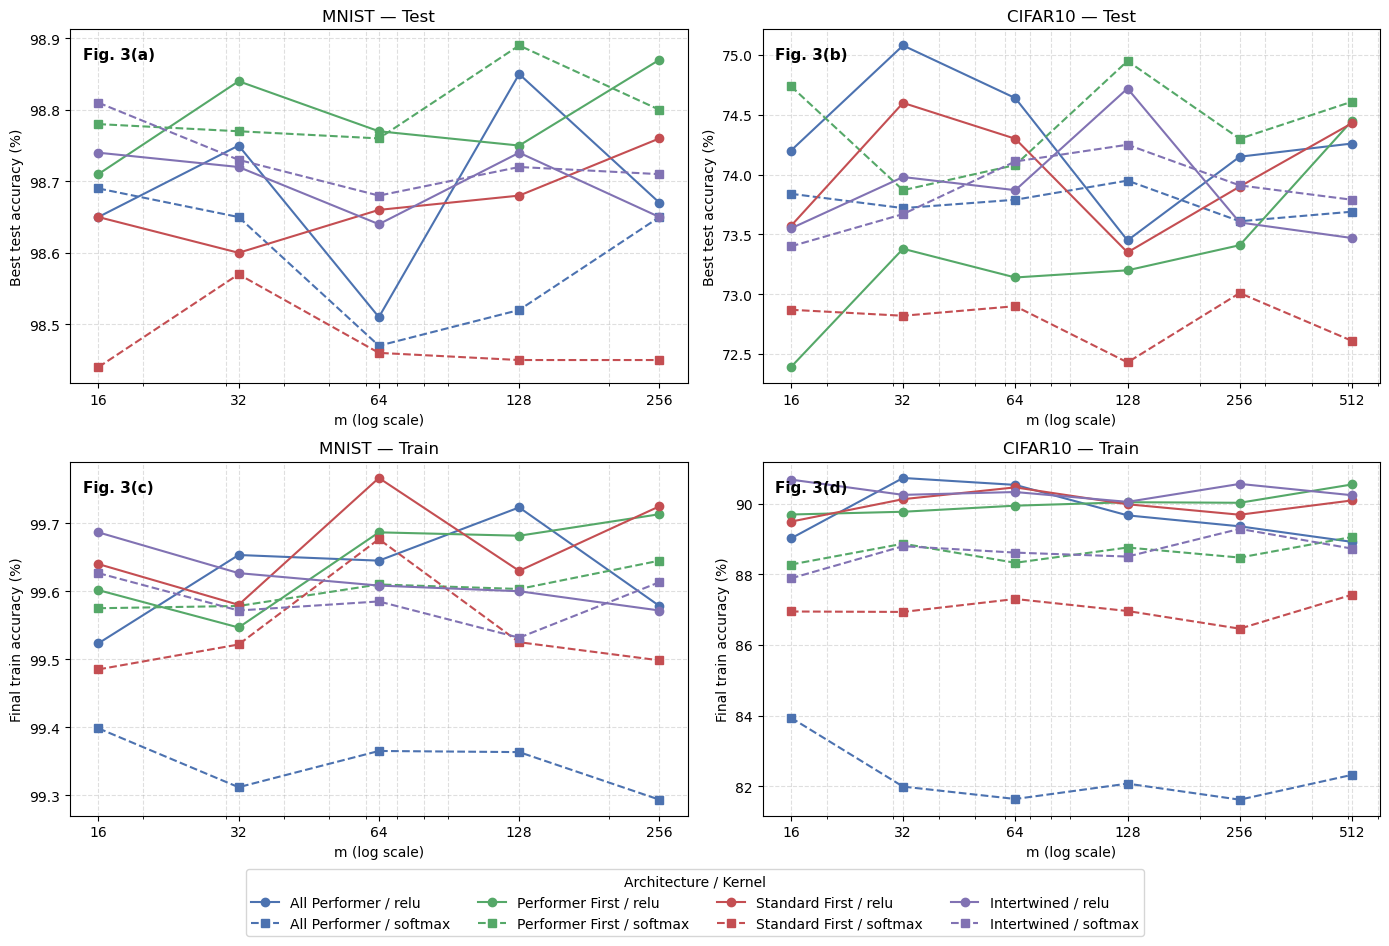

In [15]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")

results_dir = Path.cwd() / "results"
if not results_dir.exists():
    results_dir = Path.cwd().parent / "results"
if not results_dir.exists():
    raise FileNotFoundError(f"Could not find results directory from {Path.cwd()}")

arch_order = [
    ("all_performer", "All Performer"),
    ("performer_first", "Performer First"),
    ("standard_first", "Standard First"),
    ("intertwined", "Intertwined"),
]

kernels = ["relu", "softmax"]
colors = {
    "all_performer": "#4c72b0",
    "performer_first": "#55a868",
    "standard_first": "#c44e52",
    "intertwined": "#8172b3",
}
linestyles = {"relu": "-", "softmax": "--"}
markers = {"relu": "o", "softmax": "s"}


def load_test_data(dataset: str) -> pd.DataFrame:
    rows = []
    for summary_path in results_dir.glob(f"{dataset}/*summary*.csv"):
        row = pd.read_csv(summary_path).iloc[0]
        arch = row.get("architecture")
        kernel = row.get("kernel_type")
        m = row.get("m_features")
        acc = row.get("best_test_acc")
        if arch is None or arch == "all_standard":
            continue
        rows.append({
            "architecture": arch,
            "kernel_type": kernel,
            "m_features": pd.to_numeric(m, errors="coerce"),
            "value": pd.to_numeric(acc, errors="coerce"),
        })
    return pd.DataFrame(rows)


def load_train_data(dataset: str) -> pd.DataFrame:
    rows = []
    for summary_path in results_dir.glob(f"{dataset}/*summary*.csv"):
        summary_row = pd.read_csv(summary_path).iloc[0]
        arch = summary_row.get("architecture")
        kernel = summary_row.get("kernel_type")
        m = summary_row.get("m_features")
        if arch is None or arch == "all_standard":
            continue

        history_path = summary_path.with_name(summary_path.name.replace("summary_", "history_"))
        final_train_acc = None
        if history_path.exists():
            hist_df = pd.read_csv(history_path)
            if not hist_df.empty and "train_acc" in hist_df.columns:
                final_train_acc = hist_df["train_acc"].iloc[-1]

        rows.append({
            "architecture": arch,
            "kernel_type": kernel,
            "m_features": pd.to_numeric(m, errors="coerce"),
            "value": pd.to_numeric(final_train_acc, errors="coerce"),
        })
    return pd.DataFrame(rows)


def plot_panel(ax, df: pd.DataFrame, title: str, ylabel: str):
    for arch, arch_label in arch_order:
        for kernel in kernels:
            subset = df[(df["architecture"] == arch) & (df["kernel_type"] == kernel)].copy()
            subset = subset.dropna(subset=["m_features", "value"])
            if subset.empty:
                continue
            subset = subset.sort_values("m_features")
            ax.plot(
                subset["m_features"],
                subset["value"],
                label=f"{arch_label} / {kernel}",
                color=colors.get(arch),
                linestyle=linestyles[kernel],
                marker=markers[kernel],
            )

    all_m = sorted(df["m_features"].dropna().unique())
    ax.set_xscale("log")
    if all_m:
        ax.set_xticks(all_m)
        ax.set_xticklabels([str(int(m)) if float(m).is_integer() else str(m) for m in all_m])
    ax.set_xlabel("m (log scale)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.4)


fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)

# Row 0: Test acc (best); Row 1: Train acc (final)
label_grid = [["Fig. 3(a)", "Fig. 3(b)"], ["Fig. 3(c)", "Fig. 3(d)"]]
for col, ds in enumerate(["MNIST", "CIFAR10"]):
    test_df = load_test_data(ds)
    if test_df.empty:
        raise ValueError(f"No test data found for {ds} in {results_dir}")
    plot_panel(axes[0, col], test_df, f"{ds} — Test", "Best test accuracy (%)")

    train_df = load_train_data(ds)
    if train_df.empty:
        raise ValueError(f"No train data found for {ds} in {results_dir}")
    plot_panel(axes[1, col], train_df, f"{ds} — Train", "Final train accuracy (%)")

# add subplot labels
for r in range(2):
    for c in range(2):
        axes[r, c].text(
            0.02,
            0.95,
            label_grid[r][c],
            transform=axes[r, c].transAxes,
            fontsize=11,
            fontweight="bold",
            va="top",
            ha="left",
        )

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Architecture / Kernel",
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, 0.0511),
)
plt.tight_layout(rect=(0, 0.12, 1, 1))
plt.show()
